Task: Build an Artificial Neural Network to identify the customers who will be leaving the bank, based on the data of all customers over the past three months.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2025-04-10 09:10:56.559806: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 09:10:56.568846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744294256.578067    2807 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744294256.580784    2807 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744294256.589192    2807 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Task A:
## Load the dataset

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Row Numbers: Row numbers from 1 to 10000

CustomerId: Unique IDs for bank customer identification 

Surname: Customer’s Last Name 

CreditScore: Credit score of the customer 

Geography: The country that the customer
belongs to

Gender: Male or Female

Age: Age of the customer

Tenure: Number of years for which the customer has been with the bank

Balance: Bank balance of the customer

NumOfProducts: Number of bank products the customer is using

In [4]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8661,8662,15604020,Otoole,773,Germany,Female,36,4,105858.71,1,0,1,4395.45,0
7480,7481,15812766,Golubeva,490,Spain,Male,40,6,156111.08,1,0,0,190889.13,0
1928,1929,15716609,L?,484,Germany,Male,54,3,134388.11,1,0,0,49954.79,1
4781,4782,15804131,Farmer,850,Spain,Female,53,7,65407.16,2,0,0,182633.63,1
8254,8255,15664311,Yang,637,Germany,Male,28,3,123675.69,1,1,1,166458.41,0


## Drop the customers' personal data columns that will not be useful for analysis. (Hint: First three columns)

In [5]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

## Prepare independent variables X and dependent variable Y (Exited).

In [6]:
X = df.drop('Exited', axis=1)
y = df['Exited']

## LabelEncode the Gender column

In [7]:
le = LabelEncoder()
X['Gender'] = le.fit_transform(X['Gender'])

## OneHotEncode the Geography column

In [8]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
ohe = OneHotEncoder(sparse_output=False)
geography_encoded = ohe.fit_transform(df[['Geography']])
feature_names = ohe.get_feature_names_out(['Geography'])
encoded_df = pd.DataFrame(geography_encoded, columns=feature_names)

In [10]:
# one-hot 
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True,prefix='op').astype(int)

In [11]:
X.drop('Geography', axis=1, inplace=True)
X = pd.concat([X, encoded_df], axis=1)

In [12]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


## Perform a train test split in the ratio 80:20 and random_state 0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build a Keras Sequential model with the following layers:

• Dense layer with 6 neurons and activation relu

• Dense layer with 1 neuron and activation sigmoid

• Compile the model with Adam optimizer, binary_crossentropy loss and metric accuracy

In [15]:
np.random.seed(0)
tf.random.set_seed(0)   

In [16]:
from tensorflow import keras
from tensorflow.keras.layers import Dense  

model = keras.models.Sequential([
    Dense(6, activation=tf.nn.relu, input_shape=[X_train.shape[1]]),
    Dense(1, activation=tf.nn.sigmoid)
    ])

model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics= ['accuracy']
)

/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-10 09:10:58.266684: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Train the model for 10 epochs and batch size 10

In [17]:
model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=10)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5352 - loss: 0.7188 - val_accuracy: 0.7150 - val_loss: 0.5934
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.7543 - loss: 0.5557 - val_accuracy: 0.7800 - val_loss: 0.5229
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7934 - loss: 0.4956 - val_accuracy: 0.7850 - val_loss: 0.4927
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7940 - loss: 0.4677 - val_accuracy: 0.7800 - val_loss: 0.4766
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.7928 - loss: 0.4532 - val_accuracy: 0.7800 - val_loss: 0.4656
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.7981 - loss: 0.4441 - val_accuracy: 0.7800 - val_loss: 0.4581
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.8018 - loss: 0.4380 - val_accuracy: 0.7900 - val_loss: 0.4539
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.8023 - loss: 0.4336 - va

## Evaluate the model on the test set; print the accuracy and confusion matrix

In [18]:
model.evaluate(X_test,  y_test, verbose=2)

250/250 - 0s - 840us/step - accuracy: 0.8039 - loss: 0.4303


[0.4303109049797058, 0.8038750290870667]

In [19]:
y_pred = model.predict(X_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


In [20]:
accuracy = accuracy_score(y_test, y_pred.astype(int))
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.80


Confusion Matrix:
[[6364    0]
 [1636    0]]


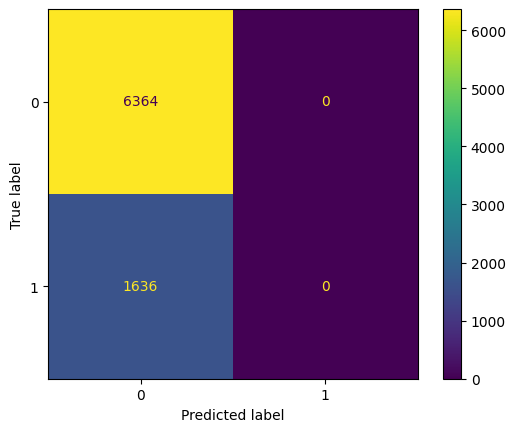

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred.astype(int))
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
# display matrix
cm_display.plot()
plt.show()

Task B:

•Use the built ANN model to predict if the customer with the following information will leave the bank:

• Geography: France

• Credit Score: 600

• Gender: Male

• Age: 40 years

• Tenure: 3 years

• Balance: $60000

• Number of Products: 2

• Does this customer have a credit card? Yes

• Is this customer an Active Member: Yes

• Estimated Salary: $50000

So, should we let the customer go?

In [22]:
X_test_person = {
'CreditScore': 600,
'Gender': 1,
'Age': 40,
'Tenure': 3,
'Balance': 60000,
'NumOfProducts': 2,
'HasCrCard': 1,
'IsActiveMember': 1,
'EstimatedSalary': 50000,
'Geography_France': 1,
'Geography_Germany': 0,
'Geography_Spain': 0,
}

X_test_person = pd.DataFrame([X_test_person])
X_test_person_scaled = scaler.transform(X_test_person)
y_pred_person = model.predict(X_test_person_scaled)
print(f"Predicted probability of exiting: {y_pred_person[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted probability of exiting: 0.07865332067012787


In [23]:
X_test_person_scaled = scaler.transform(X_test_person)

In [24]:
y_pred_person = model.predict(X_test_person_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [25]:
print(f"Predicted probability of exiting: {y_pred_person[0][0]}")

Predicted probability of exiting: 0.07865332067012787
